In [ ]:
!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

In [ ]:
!wget "https://drive.google.com/uc?export=download&id=1LPUbPd_cBSJ9AFcH79er9uzj7JKFoZzj" -O "KorQuAD_v1.0_train.csv"

--2020-11-11 06:22:15--  https://drive.google.com/uc?export=download&id=1LPUbPd_cBSJ9AFcH79er9uzj7JKFoZzj
Resolving drive.google.com (drive.google.com)... 173.194.76.113, 173.194.76.139, 173.194.76.102, ...
Connecting to drive.google.com (drive.google.com)|173.194.76.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ogc989tp7lmdumk65bkv5ite6i06e16l/1605075675000/13472183013488020071/*/1LPUbPd_cBSJ9AFcH79er9uzj7JKFoZzj?e=download [following]
--2020-11-11 06:22:17--  https://doc-08-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ogc989tp7lmdumk65bkv5ite6i06e16l/1605075675000/13472183013488020071/*/1LPUbPd_cBSJ9AFcH79er9uzj7JKFoZzj?e=download
Resolving doc-08-94-docs.googleusercontent.com (doc-08-94-docs.googleusercontent.com)... 64.233.166.132, 2a00:1450:400c:c09::84
Connecting to doc-08-94-docs.googleusercontent.com (doc-08

In [ ]:
# matplotlib에 한글 폰트 적용을 위해 아래 프로그램 설치 후 런타임 다시시작 필요
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from konlpy.tag import Mecab

import os
import time
import re

plt.rc('font', family='NanumBarunGothic') 

In [ ]:
num_samples = 50000  # 입력 데이터의 최대 sequence.
# 한글 QnA 데이터 셋 파일 경로
data_path = '/content/KorQuAD_v1.0_train.csv'
chekpoint_path = '/content/training_checkpoints' + time.strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
mecab = Mecab()

input_texts = []
target_texts = []

In [ ]:
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

In [ ]:
# 데이터 분석에 불필요한 정보 제거
def normalizeString(s):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣 ^☆; ^a-zA-Z.!?]+')
    match = hangul.search(s)
    
    result = []
    
    if not match:
      result = hangul.sub('', s)
    
    return result

In [ ]:
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

In [ ]:
for line in lines[: min(num_samples, len(lines) - 1)]:
    tmp_text = line.split('\t')
    
    if len(tmp_text) > 1:
        input_text = normalizeString(tmp_text[0])
        target_text = normalizeString(tmp_text[1])
        
    # "tab"을 목표 데이터의 시작, 종료 문자로 지정
    if len(input_text) > 0 and len(target_text) > 0:
      input_texts.append(input_text)
      target_texts.append(target_text)

In [ ]:
input_token_sequences = [mecab.morphs(sentence) for sentence in input_texts]
target_token_sequences = [['\t'] + mecab.morphs(sentence) + ['\n'] for sentence in target_texts]

In [ ]:
input_tokenizer = Tokenizer(oov_token = 'OOV')
input_tokenizer.fit_on_texts(input_token_sequences)

In [ ]:
target_tokenizer = Tokenizer(oov_token = 'OOV')
target_tokenizer.fit_on_texts(target_token_sequences)

In [ ]:
input_sequences = input_tokenizer.texts_to_sequences(input_token_sequences)
target_sequences = target_tokenizer.texts_to_sequences(target_token_sequences)

In [ ]:
num_encoder_tokens = len(input_tokenizer.word_index)
num_decoder_tokens = len(target_tokenizer.word_index)
max_encoder_seq_length = max([len(txt) for txt in input_sequences])
max_decoder_seq_length = max([len(txt) for txt in target_sequences])

In [ ]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 24754
Number of unique input tokens: 22465
Number of unique output tokens: 16266
Max sequence length for inputs: 55
Max sequence length for outputs: 22


In [ ]:
encoder_input_data = np.zeros(
    (len(input_sequences), max_encoder_seq_length),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(target_sequences), max_decoder_seq_length),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(target_sequences), max_decoder_seq_length),
    dtype='float32')

In [ ]:
input_sequences[0]

[1647, 5, 9592, 4, 5476, 12, 1384, 25, 14, 6, 435, 282, 33, 15, 2]

In [ ]:
for i, (input_id, target_id) in enumerate(zip(input_sequences, target_sequences)):
    for t, id in enumerate(input_id):
        encoder_input_data[i, t] = id
    for t, id in enumerate(target_id):
        decoder_input_data[i, t] = id
        if t > 0:
            # 디코더의 목표 데이터는 디코더 입력 데이터 보다 한 step 만큼 앞서 있음
            # 또한 디코더의 목표 데이터는 시작 문자(tab) 이 존재하지 않음
            decoder_target_data[i, t - 1] = id

In [ ]:
decoder_target_data = decoder_target_data.astype(np.int32)

In [ ]:
input_tensor_train, input_tensor_val, \
target_tensor_train, target_tensor_val = train_test_split(encoder_input_data,
                                                          decoder_target_data,
                                                          test_size=0.2)

len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(19803, 19803, 4951, 4951)

In [ ]:
EPOCHS         = 20    # 학습하고자 하는 에폭 사이즈.
BUFFER_SIZE    = len(input_tensor_train)
BATCH_SIZE     = 32    
N_BATCH        = len(input_tensor_train)//BATCH_SIZE
embedding_dim  = 256   # word 임베딩의 사이즈 
units          = 1024  # 인코더 디코더 모델의 unit 사이즈.
vocab_inp_size = num_encoder_tokens + 1 # Toknizer 에서 0 인덱스는 비워두고 1번 부터 시작
vocab_tar_size = num_decoder_tokens + 1 # Toknizer 에서 0 인덱스는 비워두고 1번 부터 시작

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units, 
                                 return_sequences=True, 
                                 return_state=True, 
                                 recurrent_activation='sigmoid', 
                                 recurrent_initializer='glorot_uniform')
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units, 
                                 return_sequences=True, 
                                 return_state=True, 
                                 recurrent_activation='sigmoid', 
                                 recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        # output shape == (batch_size, 1, hidden_size)
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [ ]:
optimizer = tf.keras.optimizers.Adam()

def loss_function(real, pred):
  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_prefix = os.path.join(chekpoint_path, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([target_tokenizer.word_index['\t']] * BATCH_SIZE,
                                       axis=1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(0, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.2946
Epoch 1 Batch 100 Loss 0.9616
Epoch 1 Batch 200 Loss 0.8738
Epoch 1 Batch 300 Loss 0.8745
Epoch 1 Batch 400 Loss 0.9260
Epoch 1 Batch 500 Loss 1.0409
Epoch 1 Batch 600 Loss 0.9290
Epoch 1 Loss 0.9483
Time taken for 1 epoch 335.2154612541199 sec

Epoch 2 Batch 0 Loss 0.8341
Epoch 2 Batch 100 Loss 0.8416
Epoch 2 Batch 200 Loss 0.8342
Epoch 2 Batch 300 Loss 0.8898
Epoch 2 Batch 400 Loss 0.7056
Epoch 2 Batch 500 Loss 0.8068
Epoch 2 Batch 600 Loss 0.9328
Epoch 2 Loss 0.8743
Time taken for 1 epoch 335.84636545181274 sec

Epoch 3 Batch 0 Loss 0.8467
Epoch 3 Batch 100 Loss 0.7767
Epoch 3 Batch 200 Loss 0.8302
Epoch 3 Batch 300 Loss 0.7897
Epoch 3 Batch 400 Loss 0.9014
Epoch 3 Batch 500 Loss 0.8182
Epoch 3 Batch 600 Loss 0.8360
Epoch 3 Loss 0.8535
Time taken for 1 epoch 335.5973858833313 sec

Epoch 4 Batch 0 Loss 0.8038
Epoch 4 Batch 100 Loss 0.7920
Epoch 4 Batch 200 Loss 0.8466
Epoch 4 Batch 300 Loss 0.9448
Epoch 4 Batch 400 Loss 0.7688
Epoch 4 Batch 500 Loss 0.9675

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
chekpoint_path = '/content/training_checkpoints2020-11-11 06:22:20'
checkpoint.restore(tf.train.latest_checkpoint(chekpoint_path))

In [ ]:
def evaluate(sentence, encoder, decoder, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    input_tokens = [mecab.morphs(sentence)]
    inputs = input_tokenizer.texts_to_sequences(input_tokens)
    inputs = pad_sequences(inputs, maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_tokenizer.word_index['\t']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += target_tokenizer.index_word[predicted_id] + ' '

        if target_tokenizer.index_word[predicted_id] == '\n':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(5,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [ ]:
def translate(sentence, encoder, decoder, max_length_inp, max_length_targ):
    result, token_sentence, attention_plot = evaluate(sentence, encoder, decoder, max_length_inp, max_length_targ)

    attention_plot = attention_plot[:len(result.split(' ')), :len(token_sentence.split(' '))]
    plot_attention(attention_plot, token_sentence.split(' '), result.split(' '))
            
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))

In [ ]:
import warnings
warnings.filterwarnings(action='ignore') 

In [ ]:
import random

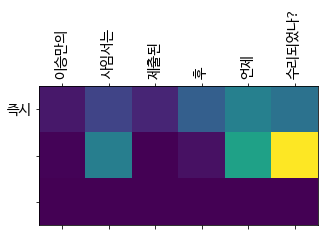

Input: 이승만의 사임서는 제출된 후 언제 수리되었나?
Predicted translation: 즉시 
 


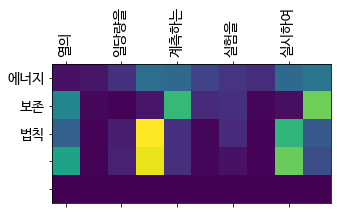

Input: 열의 일당량을 계측하는 실험을 실시하여 어떤 법칙의 확립에 도움을 주었는가?
Predicted translation: 에너지 보존 법칙 
 


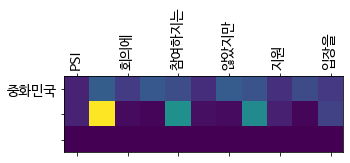

Input: PSI 회의에 참여하지는 않았지만 지원 입장을 밝히며 실질적으로 참여중인 아시아의 나라는?
Predicted translation: 중화민국 
 


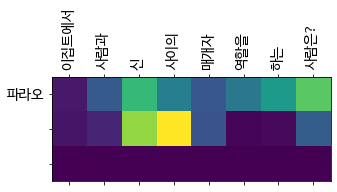

Input: 이집트에서 사람과 신 사이의 매개자 역할을 하는 사람은?
Predicted translation: 파라오 
 


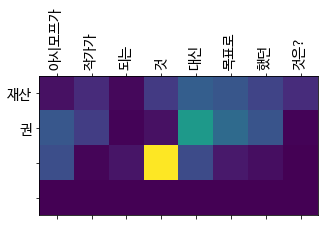

Input: 아시모프가 작가가 되는 것 대신 목표로 했던 것은?
Predicted translation: 재산 권 
 


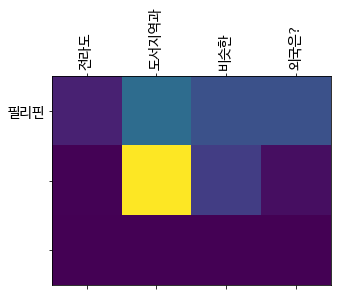

Input: 전라도 도서지역과 비슷한 외국은?
Predicted translation: 필리핀 
 


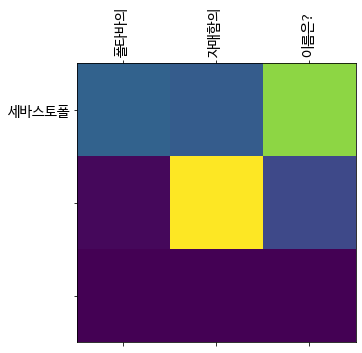

Input: 폴타바의 자매함의 이름은?
Predicted translation: 세바스토폴 
 


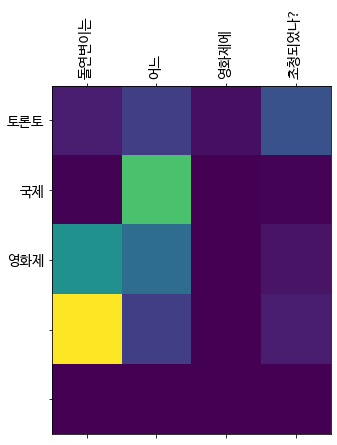

Input: 돌연변이는 어느 영화제에 초청되었나?
Predicted translation: 토론토 국제 영화제 
 


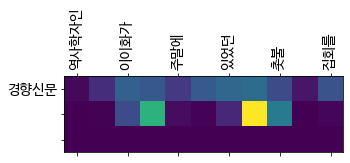

Input: 역사학자인 이이화가 주말에 있었던 촛불 집회를 언급한 칼럼이 실린 신문의 이름은?
Predicted translation: 경향신문 
 


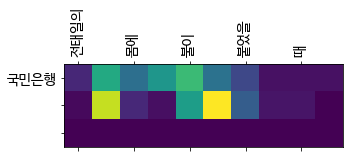

Input: 전태일의 몸에 불이 붙었을 때 그는 어느 은행 앞길로 뛰어나갔나?
Predicted translation: 국민은행 
 


In [ ]:
for text in random.sample(input_texts, 10):
  translate(text, encoder, decoder, max_encoder_seq_length, max_decoder_seq_length)

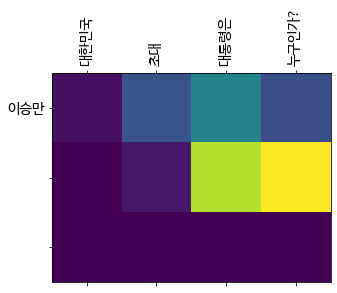

Input: 대한민국 초대 대통령은 누구인가?
Predicted translation: 이승만 
 


In [ ]:
translate('대한민국 초대 대통령은 누구인가?', encoder, decoder, max_encoder_seq_length, max_decoder_seq_length)